In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#from tensorflow_probability import edward2 as ed
import tensorflow_probability as tfp
from IPython.core import display
from neural_network import *
%matplotlib inline
%load_ext autoreload
%autoreload 2

np.random.seed(111)

In [3]:
from scipy.stats import multivariate_normal as mvn

N = 50000
x_dim = 1
y_dim = 1
noise_std_true = 0.5


# Generate data
#The dataset 1 is unimodal, the dataset 2 is multimodal

dataset_nb = 2

if dataset_nb == 1:
    b_true = np.random.randn(y_dim).astype(np.float32)   
    w_true = np.random.randn(x_dim, y_dim).astype(np.float32) 
    x = np.linspace(-10., 100., N)[None].T
    x = np.float32(x)
    noise = noise_std_true * np.random.randn(N,y_dim).astype(np.float32)
    y = np.matmul((x-50)**2, w_true)/100. + b_true + noise
    
elif dataset_nb == 2:
    radius = np.abs(np.random.normal(loc=0., scale=1., size=(N//2,1)))
    theta = np.random.uniform(low=0., high=2*np.pi, size=(N//2,1))
    x1 = radius * np.cos(theta)
    y1 = radius * np.sin(theta)
    
    radius = np.abs(np.random.normal(loc=10., scale=1., size=(N//2,1)))
    theta = np.random.uniform(low=0., high=2*np.pi, size=(N//2,1))
    x2 = radius * np.cos(theta)
    y2 = radius * np.sin(theta)
    
    x = np.vstack([x1, x2])
    y = np.vstack([y1, y2])

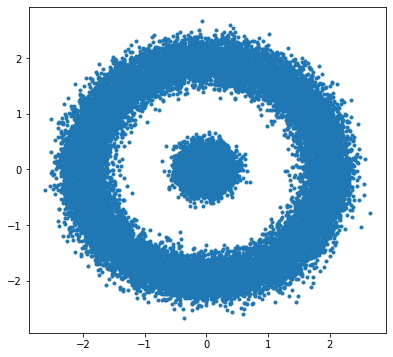

In [6]:
x = x - np.mean(x)
x /= np.std(x)
y = y - np.mean(y)
y /= np.std(y)

fig,ax = plt.subplots()
fig.set_size_inches(6.4, 6)
plt.plot(x[:,0], y[:,0], ".")

N = x.shape[0]

In [7]:
def sample_data(batch):
    ind = np.random.randint(low=0, high=N, size=(batch,))
    return x[ind], y[ind]

## Create the generator and the discriminator

In [8]:
z_dim = 10

In [9]:
gen  = MLP([z_dim] + [200,200] + [x_dim + y_dim], batch_size=1)
disc = MLP([x_dim + y_dim] + [100,100] + [1], batch_size=1)

In [10]:
optimizer_disc = tf.keras.optimizers.RMSprop(lr=0.00005)
optimizer_gen = tf.keras.optimizers.RMSprop(lr=0.00005)

In [11]:
@tf.function
def train_step_discriminator(xy_real, xy_fake):
    n = xy_real.shape[0]
    with tf.GradientTape() as tape:
        loss = -(tf.reduce_mean(disc.forward_pass(xy_real)[0] - disc.forward_pass(xy_fake)[0]))
    
    gradients = tape.gradient(loss, disc.trainable_variables)
    optimizer_disc.apply_gradients(zip(gradients, disc.trainable_variables))
    for i,weights in enumerate(disc.trainable_variables):
        disc.trainable_variables[i].assign(tf.clip_by_value(weights, -0.01, 0.01))
    return loss, gradients   

In [12]:
@tf.function
def train_step_generator(z):
    n = z.shape[0]
    with tf.GradientTape() as tape:        
        xy_fake = gen.forward_pass(z)[0]
        loss = -tf.reduce_mean(disc.forward_pass(xy_fake)[0])
    
    gradients = tape.gradient(loss, gen.trainable_variables)
    optimizer_gen.apply_gradients(zip(gradients, gen.trainable_variables))
    return loss, gradients

In [13]:
batch= 64

In [ ]:
plotting = True

avgs_real = []
avgs_fake = []

for epoch in range(100000):
    try: 
        
        if epoch < 25 or epoch % 500 == 0:
            n_critic = 100
        else:
            n_critic = 5
            
        for k in range(n_critic):
            # Train discriminator
            z = tf.random.normal((batch,z_dim ))
            x_, y_ = sample_data(batch)
            xy_real = tf.concat([x_,y_],-1)
            xy_fake = gen.forward_pass(z)[0]

            loss_disc, grad_disc = train_step_discriminator(xy_real, xy_fake)


        # Train generator
        z = tf.random.normal((batch,z_dim ))
        loss_gen, grad_gen = train_step_generator(z)
        
        display.clear_output(wait=True)
        
        avg_real = disc.forward_pass(xy_real)[0].numpy().mean()
        avg_fake = disc.forward_pass(xy_fake)[0].numpy().mean()
        print("Epoch: {}, Avg real: {:.4f}, Avg fake: {:.4f}".format(epoch, avg_real, avg_fake))
        
        avgs_real.append(avg_real)
        avgs_fake.append(avg_fake)
        
        if plotting and epoch % 100 == 0:
            plt.clf()
            fig,ax = plt.subplots()
            ax.plot(x[:,0], y[:,0], "k.")
            z = tf.random.normal((N, z_dim))
            xy_test = gen.forward_pass(z)[0]
            ax.plot(xy_test[:,0], xy_test[:,1], "b.", alpha=0.1)
            plt.savefig('images/epoch{}'.format(epoch))
        
    except KeyboardInterrupt:
            break

Epoch: 37400, Avg real: 0.0100, Avg fake: 0.0100


In [ ]:
z1 = np.zeros(10)
z2 = np.zeros(10)
z = np.vstack([z1, z2])

In [67]:
def lin_interpolate(z1, z2, N=10):
    z = []
    for i in range(N):
        z += [z1 + (i*1./N)*(z2-z1)]
    z += [z2]
    return np.array(z)

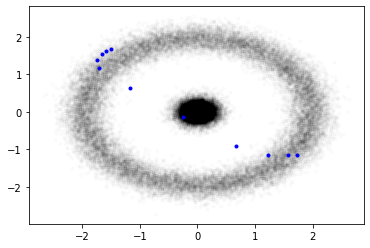

In [167]:
fig,ax = plt.subplots()
ax.plot(x[:,0], y[:,0], "k.", alpha = 0.01)
#z = tf.random.normal((10, z_dim))
# z = np.zeros((10, 10))
# z[:,1] = 1*np.ones(10)
# z[:,0] = 0.5*np.ones(10)
# z1 = np.zeros(10)
# z1[1] = 1
# z1[0] = -1
# z2 = np.zeros(10)
# z2[1] = 1
# z2[0] = 1
# z2[7] = 0
z = lin_interpolate(z1, z2, 10)

xy_test = gen.forward_pass(z)[0]
ax.plot(xy_test[:,0], xy_test[:,1], "b.", alpha=1)

tf.Tensor(
[[-0.5012891   0.3908673  -0.41350052  0.13564752 -1.2330153   0.31623247
   2.30524    -0.32436672  0.07466716  1.2289076 ]], shape=(1, 10), dtype=float32)


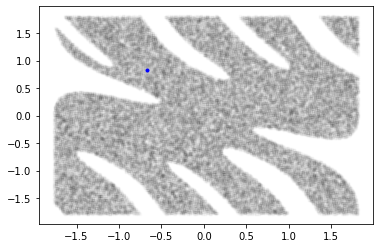

In [18]:
fig,ax = plt.subplots()
ax.plot(x[:,0], y[:,0], "k.", alpha = 0.01)
z = tf.random.normal((1, z_dim))
print(z)


xy_test = gen.forward_pass(z)[0]
ax.plot(xy_test[:,0], xy_test[:,1], "b.", alpha=1)

In [117]:
z1 = z.numpy().flatten()

In [165]:
z2 = z.numpy().flatten()

<Figure size 432x288 with 0 Axes>

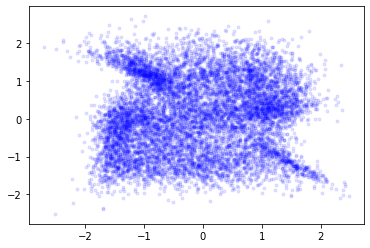

In [23]:
plt.clf()
fig,ax = plt.subplots()
#ax.plot(x[:,0], y[:,0], "k.")
z = tf.random.normal((10000, z_dim))
xy_test = gen.forward_pass(z)[0]
ax.plot(xy_test[:,0], xy_test[:,1], "b.", alpha=0.1)
plt.savefig('images/epoch{}'.format(epoch))